# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## [Final Project] Social Media Toxicity Shield: Milestone 4


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

In [42]:
# Library Imports
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from collections import Counter\

from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall, MeanIoU, AUC, BinaryAccuracy
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.cluster import KMeans

In [2]:
# Issues with the below imports on my local machine—will likely resort to JupyterHub
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

<a id="contents"></a>
# Table of Contents
1. [**Problem Statement Refinement and Introduction**](#intro)
2. [**Comprehensive EDA Review**](#eda)
    - [**Key EDA Findings**](#find)
    - [**Initial Preprocessing**](#preprocess1)
    - [**Additional Preprocessing**](#preprocess2)
3. [**Modeling**](#model)
    - [**Baseline Model Choice**](#choice)
    - [**Training Process**](#train)
    - [**Initial Results**](#result)
4. [**Results Interpretation & Analysis**](#interp)
    - [**Analysis of Baseline Model Performance**](#analysis)
    - [**Proposed Improvements**](#improve)
5. [**Final Model Pipeline**](#final)
    - [**Assumptions, Parameter Choices, and Preliminary Tuning Considerations**](#assum)

<a id="intro"></a>

# 1. Problem Statement Refinement and Introduction

[Return to contents](#contents)

## Introduction
Online platforms vary widely in functionality and purpose, yet they all face a common problem: toxic content. Harmful posts can negatively impact users’ well-being—contributing to anxiety, depression, and other mental-health issues—and rely heavily on human moderators to keep forums safe. Although many platforms censor slurs or profanity, toxicity often goes beyond “bad words.” With today’s advanced tools, we have an opportunity to monitor—and mitigate—toxicity more effectively.

As a reminder, we’re using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains approximately 1.9 million comments labeled for various forms of toxicity.

## Problem Statement
- **Primary goal:** How can we reliably predict the toxicity of online comments?  
- **Secondary goals:** Which features contribute most to toxicity, and how can we assess our model’s fairness across different identity attributes?  
  In particular, many comments containing identity markers are labeled toxic more often than not—so we need to ensure our model can accurately detect toxicity regardless of such markers.

## Addressing Prior Feedback
Our earlier approach involved oversampling the minority (toxic) class, then applying a penalty to minority-class predictions—a contradictory strategy. We’ve removed that penalty to align sampling and loss functions.

## Adjusted Significance
Our earlier EDA reveals a severe class imbalance: non-toxic comments far outnumber toxic ones. To address this, we’ll optimize not only for overall accuracy but also for precision and recall—ensuring each class is identified correctly. We also take reassurance in knowing that toxic comments comprise only a small fraction of the dataset.


<a id="eda"></a>

# 2. Comprehensive EDA Review
[Return to contents](#contents)

<a id="find"></a>

## Key EDA Findings

[Return to contents](#contents)

- The most frequent words in toxic comments often have political connotations or express societal opinions (e.g., “people,” “state”). 
    - This doesn’t impact our feature engineering—just an interesting observation.  
- There is a significant class imbalance in the `toxic` class, as well as in most other variables (except `insult`):  
  - We combined the `severe_toxic` and `toxic` labels, since both capture the outcome we care about—whether a comment is toxic.  
  - To keep our training corpus robust, we will upsample toxic comments
  - When we have more time, we would also leverage a GPT-based generator to introduce more variety into the positive class.  
- The `insult` and `toxic` labels are highly correlated (0.75), while `toxic` shows only weak correlations with other predictors—another obvious but noteworthy point: toxicity often manifests as insults.  
- Most comments are under 250 characters, with frequency decaying exponentially until around 1,000 characters, where there’s a slight uptick (see image below). 
    - This pattern likely won’t affect feature extraction, but it may guide our choice of maximum sequence length for the tokenizer.

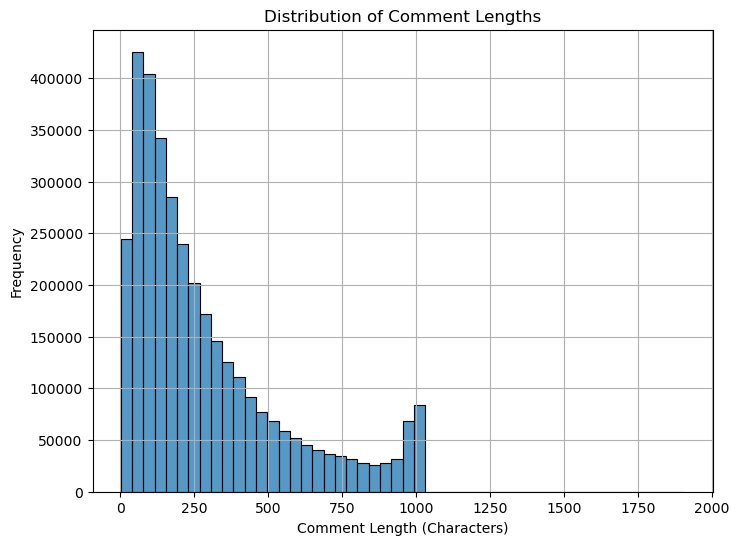

---

<a id="preprocess1"></a>

## Initial Preprocessing (MS2 & MS3)
[Return to contents](#contents)

1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 
2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.
3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.
4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.
5. [MS3] We combined the `severe_toxic` and `toxic` class.

### 1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 

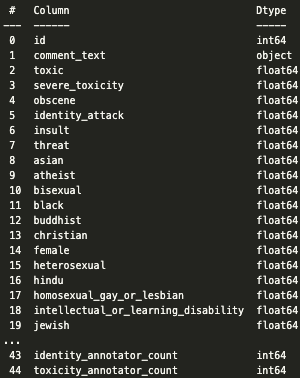

---

### 2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.

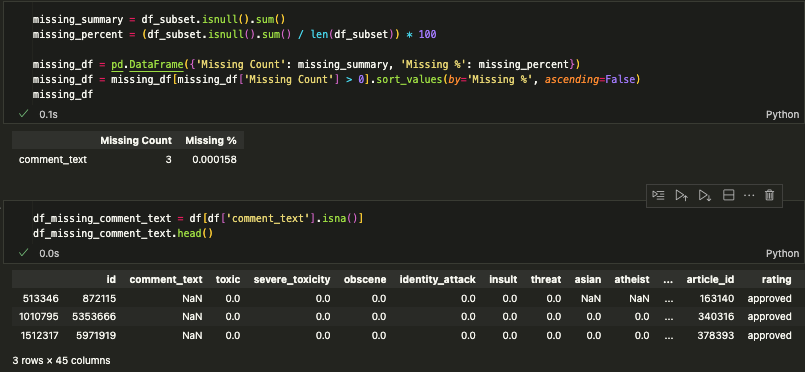

---

### 3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.

---

### 4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.

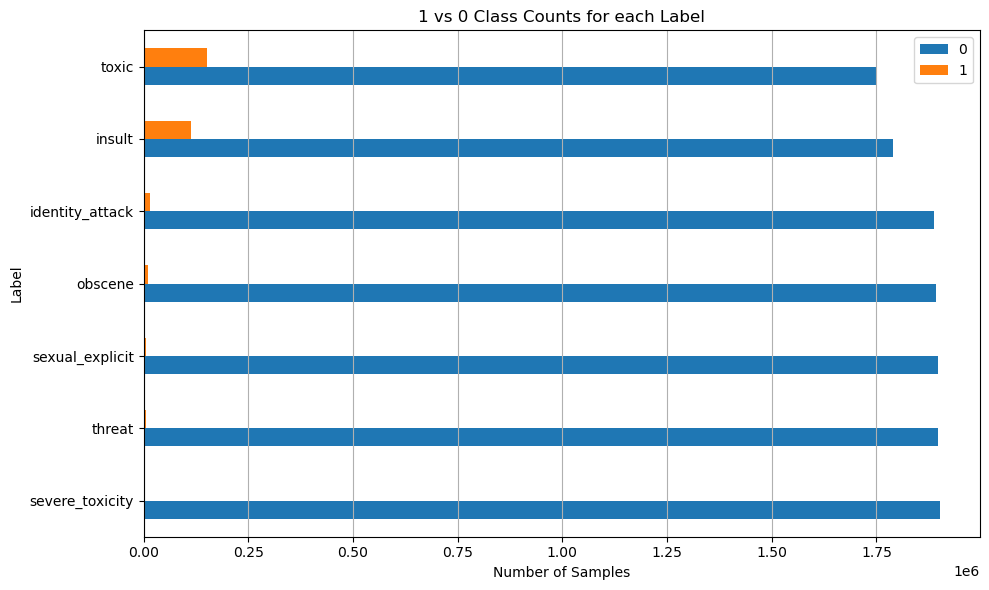

---

<a id="preprocess2"></a>

## Additional Preprocessing

[Return to contents](#contents)

##### We are going to start by combining the `severe_toxic` and `toxic` class

In [3]:
# Read the data
df = pd.read_csv("data/cleaned_ms2_data.csv")
df.head(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0


In [ ]:
# Combine toxic and severe_toxicity
df['toxic'] = df['toxic'] | df['severe_toxicity']
df = df.drop(columns=['severe_toxicity'])

In [6]:
# Hold out a stratified test set
X = df['comment_text']
y = df['toxic']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=109,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.10,
    random_state=109,
    stratify=y_temp
)

# Reconstruct train‐frame
train_df = pd.DataFrame({'comment_text': X_train, 'toxic': y_train})

---

##### Upsample the `toxic` class in training set 

In [10]:
# Separate toxic and non-toxic comments
train_df = pd.DataFrame({'comment_text': X_train, 
                         'toxic': y_train})
tox = train_df[train_df.toxic == 1]
nontox = train_df[train_df.toxic == 0]

# Upsample the toxic class to match non-toxic size
tox_upsampled = resample(
    tox,
    replace=True,
    n_samples=len(nontox),
    random_state=109
)

train_balanced = pd.concat([nontox, tox_upsampled]).sample(frac=1, random_state=109)
train_balanced.toxic.value_counts()

toxic
0    1575071
1    1575071
Name: count, dtype: int64

##### The stage is now set for tokenization and to train the model!

<a id="model"></a>

# 3. Modeling
[Return to contents](#contents)

#### Baseline Model: DistilBERT 

[Question asks for: 
- Explain the choice of your baseline model, considering simplicity, interpretability, and relevance.
- Detail the training process, including preprocessing, parameters, and metrics used for evaluation.
- Present initial results, discussing alignment with expectations and project objectives]

We chose this as a baseline model for a few reasons:
- We used this in Lab 10 to help us with sentiment analysis, and we are doing an isomorphic problem



Process:
1. Turn `X_train` and `X_test` into lists of string
2. Turn `y_train` and `y_test` into numpy arrays
3. Tokenize 

In [41]:
# Get the model and tokenizer
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                             num_labels=1,
                                                             problem_type="single_label_classification")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

#### ChatGPT helped me debug the tokenization problem I had (which was that I was passing a Series object into the tokenizer, instead of a string or list of strings

In [9]:
# Tokenize each set
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

enc_train = tokenize_texts(X_train)
enc_val   = tokenize_texts(X_val)
enc_test  = tokenize_texts(X_test)

In [11]:
# create my datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(enc_train), y_train.values)) \
                       .shuffle(10_000).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((dict(enc_val),   y_val.values)) \
                       .batch(32)
test_ds  = tf.data.Dataset.from_tensor_slices((dict(enc_test),  y_test.values)) \
                       .batch(32)

In [15]:
# Yikes, our data size has increased significantly...
len(enc_train['input_ids'])

380439

In [38]:
# For the purpose of this milestone, we are going to use significantly less data (helped by ChatGPT)
def sample_balanced_dataset(dataset, n_per_class, batch_size=32, shuffle_buffer=None, seed=198):
    """
    Returns a smaller, balanced tf.data.Dataset by sampling n_per_class examples
    from each class in the given dataset. The input dataset can be batched;
    it will be unbatched first, then filtered, sampled, recombined,
    optionally shuffled, and re-batched.
    
    Args:
        dataset: tf.data.Dataset yielding (features, label) pairs, where label is 0 or 1.
        n_per_class: int, number of examples to sample for each class.
        batch_size: int, the batch size for the returned dataset.
        shuffle_buffer: int or None, buffer size for shuffling; if None, no shuffle applied.
        seed: int, random seed for shuffle.
    """
    ds = dataset.unbatch()
    pos = ds.filter(lambda x, y: tf.equal(y, 1)).take(n_per_class)
    neg = ds.filter(lambda x, y: tf.equal(y, 0)).take(n_per_class)
    small = pos.concatenate(neg)
    if shuffle_buffer:
        small = small.shuffle(shuffle_buffer, seed=seed)
    return small.batch(batch_size)

In [39]:
small_train_ds = sample_balanced_dataset(
    train_ds, 
    n_per_class=2000, 
    batch_size=32, 
    shuffle_buffer=4000
)
small_val_ds = sample_balanced_dataset(
    val_ds, 
    n_per_class=500, 
    batch_size=32, 
    shuffle_buffer=1000
)
small_test_ds = sample_balanced_dataset(
    test_ds, 
    n_per_class=500, 
    batch_size=32, 
    shuffle_buffer=1000
)

In [43]:
# Borrowing Code from Lab 10
lr = 1e-5
epochs  = 5   # with early stopping, this is plenty

def scheduler(epoch, lr):
    warmup_epochs = 1
    decay_epochs  = epochs - warmup_epochs
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    else:
        return lr * (1 - (epoch - warmup_epochs) / decay_epochs)

# 2) Callbacks
checkpoint_filepath = "distilbert_best.weights.h5"
checkpoint_cb = ModelCheckpoint(
    "best.weights.h5",
    save_weights_only=True,
    monitor="val_AUPRC",
    mode="max",
    save_best_only=True
)

earlystop_cb = EarlyStopping(
    monitor="val_AUPRC",
    patience=2,
    restore_best_weights=True,
    verbose=1
)

lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [44]:
# Define F1 score, Normalized Entropy, and initilize AUPRC (ChatGPT assisted)
# Custom F1 for binary logits
class F1Binary(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.prec = Precision()
        self.rec  = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        probs = tf.math.sigmoid(y_pred)             # [batch,1]
        preds = tf.cast(probs > 0.5, tf.int32)      # threshold
        self.prec.update_state(y_true, preds, sample_weight)
        self.rec .update_state(y_true, preds, sample_weight)

    def result(self):
        p = self.prec.result()
        r = self.rec.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.prec.reset_states()
        self.rec.reset_states()

# Normalized Entropy using BCE
p_pos = y_train.mean()  # fraction of positives in TRAIN
import numpy as np
baseline_ce = float(-(p_pos * np.log(p_pos) + (1-p_pos)*np.log(1-p_pos)))

class NormalizedEntropyBinary(tf.keras.metrics.Metric):
    def __init__(self, baseline_ce, name="normalized_entropy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.baseline_ce = tf.constant(baseline_ce, dtype=tf.float32)
        self.total_ce    = self.add_weight("total_ce", initializer="zeros")
        self.count       = self.add_weight("count", initializer="zeros")
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def update_state(self, y_true, y_pred, sample_weight=None):
        ce = self.bce(y_true, y_pred)
        self.total_ce.assign_add(ce)
        self.count   .assign_add(1.0)

    def result(self):
        return (self.total_ce / self.count) / self.baseline_ce

    def reset_states(self):
        self.total_ce.assign(0.0)
        self.count   .assign(0.0)

auprc = AUC(curve="PR", name="AUPRC")

In [45]:
# Build and compile
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        BinaryAccuracy(name="accuracy"),
        Precision(name="precision"),
        Recall(name="recall"),
        F1Binary(),
        auprc,
        NormalizedEntropyBinary(baseline_ce)
    ]
)

In [46]:
# Fit
history = model.fit(
    small_train_ds,
    validation_data=small_val_ds,
    epochs=5,
    callbacks=[checkpoint_cb, earlystop_cb, lr_callback],
    use_multiprocessing=True,
    workers=-1
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/5
    125/Unknown - 36s 185ms/step - loss: 0.5439 - accuracy: 0.7013 - precision: 0.8676 - recall: 0.4750 - f1_score: 0.7412 - AUPRC: 0.7885 - normalized_entropy: 1.9516

2025-04-28 23:10:52.475787: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16669636348538962866
2025-04-28 23:10:52.475831: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4194144910428272324
2025-04-28 23:10:52.475840: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7503251710208961411
2025-04-28 23:10:52.475846: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2494961350044403595
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Binary implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/sit

125/125 [==============================] - 42s 235ms/step - loss: 0.5439 - accuracy: 0.7013 - precision: 0.8676 - recall: 0.4750 - f1_score: 0.7412 - AUPRC: 0.7885 - normalized_entropy: 1.9361 - val_loss: 0.3912 - val_accuracy: 0.8480 - val_precision: 0.8175 - val_recall: 0.8960 - val_f1_score: 0.8512 - val_AUPRC: 0.8350 - val_normalized_entropy: 1.3887 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/5
125/125 [==============================] - 29s 227ms/step - loss: 0.3513 - accuracy: 0.8550 - precision: 0.8781 - recall: 0.8245 - f1_score: 0.8588 - AUPRC: 0.8634 - normalized_entropy: 1.2606 - val_loss: 0.3148 - val_accuracy: 0.8710 - val_precision: 0.8922 - val_recall: 0.8440 - val_f1_score: 0.8766 - val_AUPRC: 0.8759 - val_normalized_entropy: 1.1346 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 7.499999810534064e-06.
Epoch 3/5
125/125 [==============================] - 26s 205ms/step - loss: 0.2829 -

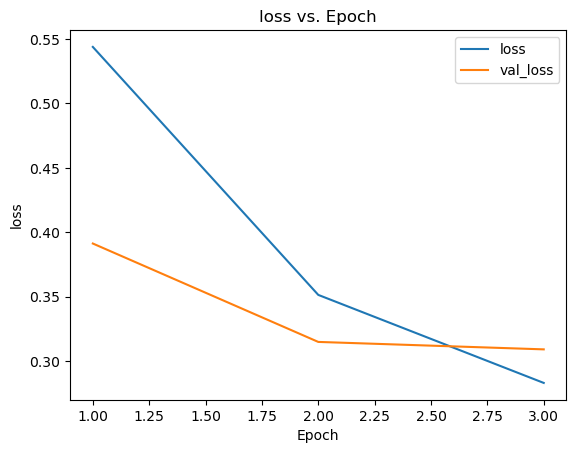

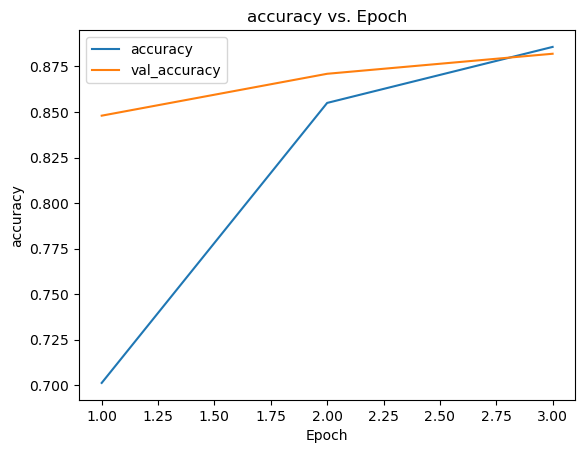

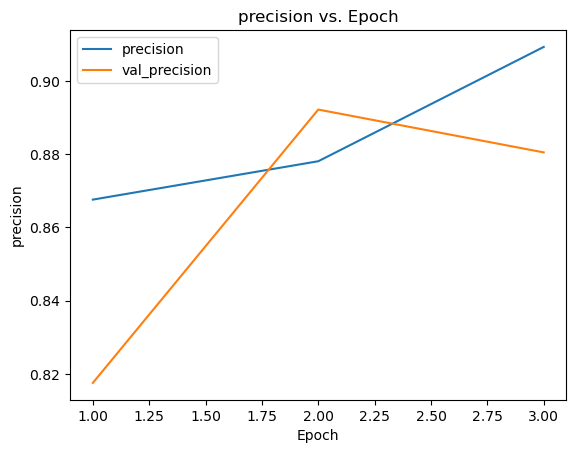

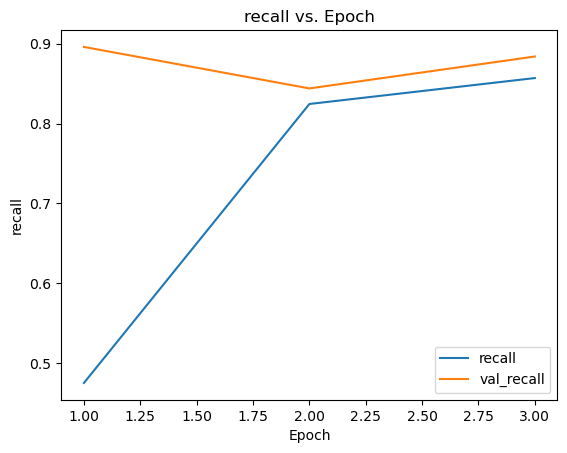

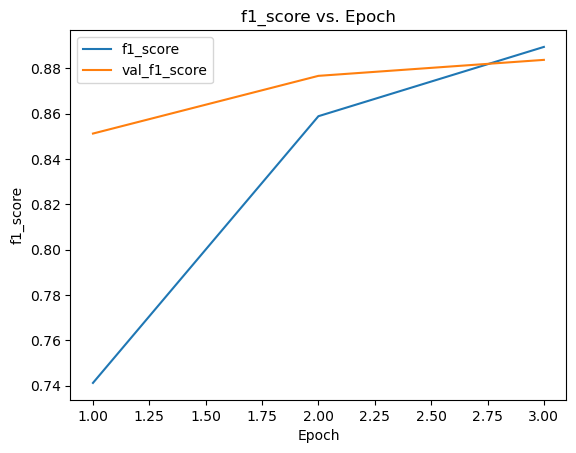

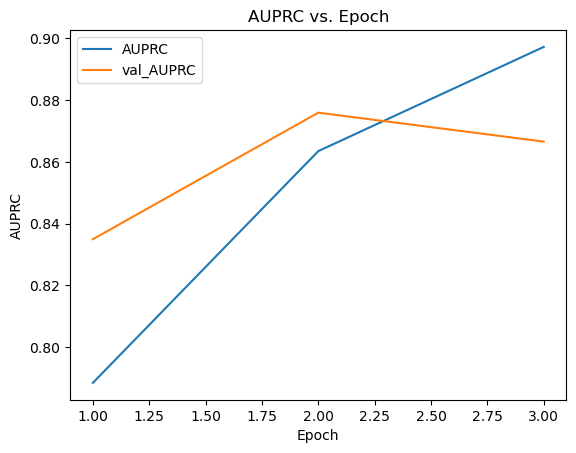

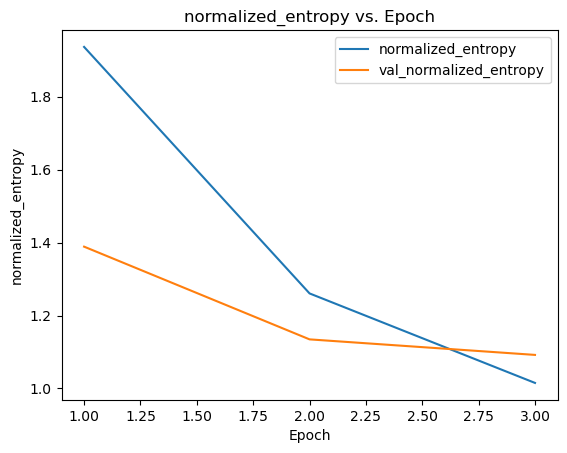

In [47]:
# Plot metrics vs. Epochs
hist = history.history
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC', 'normalized_entropy']
epochs = range(1, len(hist['loss']) + 1)

for metric in metrics:
    plt.figure()
    plt.plot(epochs, hist[metric],      label=metric)
    plt.plot(epochs, hist[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Epoch')
    plt.legend()
    plt.show()


<a id="choice"></a>

## Baseline Model Choice
[Return to contents](#contents)

<a id="train"></a>

## Training Process
[Return to contents](#contents)

<a id="result"></a>

## Initial Results
[Return to contents](#contents)

<a id="interp"></a>

# 4. Results Interpretation & Analysis
[Return to contents](#contents)

<a id="analysis"></a>

## Analysis of Baseline Model Performance
[Return to contents](#contents)

<a id="improve"></a>

## Proposed Improvements
[Return to contents](#contents)

<a id="final"></a>

# 5. Final Model Pipeline
[Return to contents](#contents)

<a id="assum"></a>

## Assumptions, Parameter Choices, and Preliminary Tuning Considerations
[Return to contents](#contents)